In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import math

import time
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, zero_one_loss, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import callbacks
from keras import losses
from tensorflow.keras.models import save_model, load_model

2024-11-25 12:00:41.962204: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 12:00:41.963880: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 12:00:41.968203: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 12:00:41.977121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732536041.988326   20282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732536041.99

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

W0000 00:00:1732536043.120664   20282 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

# Dataset loading and visualization

In [4]:
colonne=pd.read_csv('./kddcup.names',sep=':',skiprows=1,header=None)

attacchi=pd.DataFrame(['attack_type'])

hn=pd.concat([colonne,attacchi],ignore_index=True)
header_names=hn.iloc[:,0].tolist()

print(header_names,'\n')

data = pd.read_csv('./data_no_dup.csv',names=header_names)

label=data['attack_type']
data=data.drop(['attack_type'],axis=1)


['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'] 



In [5]:
print(data.describe,'\n')
print(label.shape,'\n')
print(label.describe,'\n')

<bound method NDFrame.describe of          duration protocol_type service flag  src_bytes  dst_bytes  land  \
0               0           tcp    http   SF        215      45076     0   
1               0           tcp    http   SF        162       4528     0   
2               0           tcp    http   SF        236       1228     0   
3               0           tcp    http   SF        233       2032     0   
4               0           tcp    http   SF        239        486     0   
...           ...           ...     ...  ...        ...        ...   ...   
1074987         0           tcp    http   SF        212       2288     0   
1074988         0           tcp    http   SF        219        236     0   
1074989         0           tcp    http   SF        218       3610     0   
1074990         0           tcp    http   SF        219       1234     0   
1074991         0           tcp    http   SF        219       1098     0   

         wrong_fragment  urgent  hot  ...  dst_host_c

In [6]:
col_names = np.array(header_names)
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

#print('Nominal: ',nominal_idx)
#for j in nominal_idx: print(header_names[j])
#print()

#print('Binary: ', binary_idx)
#for j in binary_idx: print(header_names[j])
#print()

#print('Numeric: ',numeric_idx)
#for j in numeric_idx: print(header_names[j])

nominal_column=col_names[nominal_idx].tolist()
binary_column=col_names[binary_idx].tolist()
numeric_column=col_names[numeric_idx].tolist()

#print('\nNumeric: ',pd.Series(numeric_column).count(), '\nBinary: ', pd.Series(binary_column).count(), '\nNominal: ',pd.Series(nominal_column).count())

attack_type
normal.             812814
neptune.            242149
satan.                5019
ipsweep.              3723
portsweep.            3564
smurf.                3007
nmap.                 1554
back.                  968
teardrop.              918
warezclient.           893
pod.                   206
guess_passwd.           53
buffer_overflow.        30
warezmaster.            20
land.                   19
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64


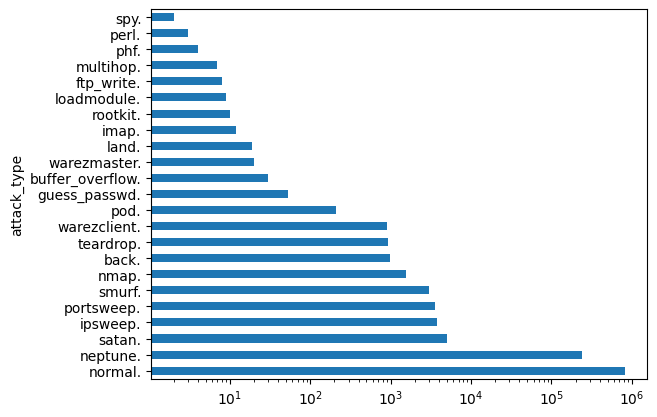

In [7]:
from collections import defaultdict
category = defaultdict(list)
category['benign'].append('normal.')
with open('./training_attack_types.txt', 'r') as ff:
    for line in ff.readlines():
        attack_name, attack_cat = line.strip().split(' ')
        category[attack_cat].append(attack_name)

#print(category)

attack_mapping = dict((a,c) for c in category for a in category[c])
#print('\nAttack mapping: ',attack_mapping,'\n')

attacchi=label.value_counts()
print(attacchi)
attacchi.plot(kind='barh')
plt.xscale('log')

attack_type
benign    812814
dos       247267
probe      13860
r2l          999
u2r           52
Name: count, dtype: int64


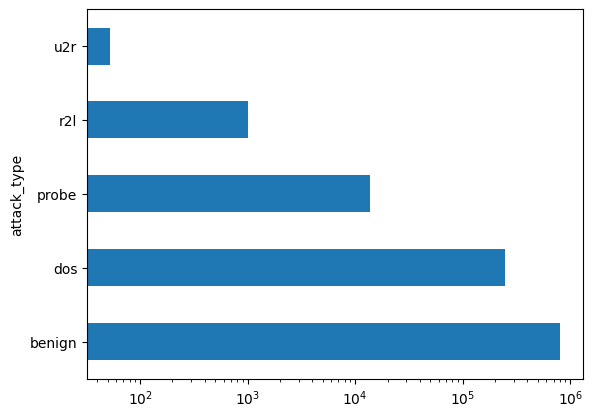

In [8]:
label_cat=label.map(lambda x: attack_mapping[x])
categorie_attacchi=label_cat.value_counts()
print(categorie_attacchi)
categorie_attacchi.plot(kind='barh')
plt.xscale('log')

# Data analysis and fixing

In [9]:
#data[binary_column].describe().transpose()


In [10]:
#data[nominal_column].describe().transpose()

In [11]:
#data['protocol_type'].unique()

In [12]:
#data[numeric_column].describe().transpose()

In [13]:
# In the category 'su_attempted' the maximum is 2 altough it is binary, we have to fix it
#data.groupby(['su_attempted']).size()


In [14]:
data['su_attempted'].replace(2,1,inplace=True)
#data.groupby(['su_attempted']).size()

/tmp/ipykernel_20282/810226542.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['su_attempted'].replace(2,1,inplace=True)


In [15]:
# In the category 'su_attempted' the maximum count is 0, thus we can safely remove it
#data.groupby(['num_outbound_cmds']).size()


In [16]:
data.drop('num_outbound_cmds', axis=1, inplace=True)
ind=numeric_column.index('num_outbound_cmds')
numeric_column.remove('num_outbound_cmds')
numeric_idx.remove(ind)

In [17]:
print('Numeric: ',pd.Series(numeric_column).count(), '\nBinary: ', pd.Series(binary_column).count(), '\nNominal: ',pd.Series(nominal_column).count())

Numeric:  31 
Binary:  6 
Nominal:  3


# Data preparation

In [18]:
data_raw = pd.get_dummies(data, columns=nominal_column, drop_first=True)


In [19]:
data.shape

(1074992, 40)

In [20]:
data_raw.shape

(1074992, 118)

In [21]:
dummy_variables = list(set(data_raw) - set(data))
#print(dummy_variables)

# Create a classification dataset

In [22]:
#label_cat_bin = label_cat.apply(lambda x: 'benign' if x == 'benign' else 'attack')

In [23]:
#np.array(X_train_t)
#np.array(X_train_t)

In [24]:
#ca=label_cat_bin.value_counts()
#print(ca,'\n')
ca_train=label_cat.value_counts()
#ca_test=y_test.value_counts()
print('Training:\n',ca_train)#,'\n\nTest: \n',ca_test)

Training:
 attack_type
benign    812814
dos       247267
probe      13860
r2l          999
u2r           52
Name: count, dtype: int64


In [25]:
# split dataset -> train + test dataset
label_cat_dummies=pd.get_dummies(label_cat, drop_first=False)
label_cat_num=np.array(label_cat_dummies)

#data_raw_numpy=np.array(data_raw)

print(label_cat_num.shape,'\n')
#print(label_cat_num[1:15],'\n')
label_ann=list(label_cat_dummies)
print(label_ann,'\n')

X_train, X_test, y_train, y_test = train_test_split(data_raw, label_cat_num, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape,X_train.shape[0]+X_test.shape[0],len(data_raw))

(1074992, 5) 

['benign', 'dos', 'probe', 'r2l', 'u2r'] 

(859993, 118) (214999, 118) 1074992 1074992


In [26]:
X_train.shape

(859993, 118)

In [27]:
X_test.shape

(214999, 118)

In [28]:
y_test.shape

(214999, 5)

In [29]:
# split train -> train_t + validation dataset
X_train_t, X_val, y_train_t, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


## Regularization of numeric features

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#train_data_std = X_train
#test_data_std = X_test

scaler = MinMaxScaler().fit(X_train_t[numeric_column])

#train_data_std.loc[:,numeric_column] = standard_scaler.transform(train_data_std[numeric_column])
#test_data_std.loc[:,numeric_column] = standard_scaler.transform(test_data_std[numeric_column])

X_train_t[numeric_column] = scaler.transform(X_train_t[numeric_column])
X_test[numeric_column] = scaler.transform(X_test[numeric_column])
X_val[numeric_column] = scaler.transform(X_val[numeric_column])



In [31]:
X_train_t[binary_column].describe().transpose()


count      mean       std  min  25%  50%  75%  max
land            687994.0  0.000020  0.004511  0.0  0.0  0.0  0.0  1.0
logged_in       687994.0  0.629405  0.482964  0.0  0.0  1.0  1.0  1.0
root_shell      687994.0  0.000285  0.016876  0.0  0.0  0.0  0.0  1.0
su_attempted    687994.0  0.000106  0.010300  0.0  0.0  0.0  0.0  1.0
is_host_login   687994.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
is_guest_login  687994.0  0.003817  0.061663  0.0  0.0  0.0  0.0  1.0

In [32]:
X_train_t[dummy_variables].describe().transpose()

count unique    top    freq
service_remote_job   687994      2  False  687346
flag_S1              687994      2  False  687644
service_ctf          687994      2  False  687302
service_link         687994      2  False  687315
service_daytime      687994      2  False  687310
...                     ...    ...    ...     ...
service_X11          687994      2  False  687915
service_netbios_ssn  687994      2  False  687353
service_uucp_path    687994      2  False  687313
service_netstat      687994      2  False  687330
service_gopher       687994      2  False  687322

[81 rows x 4 columns]

In [33]:
X_train_t[numeric_column].describe().transpose()

count      mean       std  min       25%  \
duration                     687994.0  0.002286  0.022336  0.0  0.000000   
src_bytes                    687994.0  0.000006  0.001794  0.0  0.000000   
dst_bytes                    687994.0  0.000010  0.001707  0.0  0.000000   
wrong_fragment               687994.0  0.000885  0.029010  0.0  0.000000   
urgent                       687994.0  0.000003  0.001277  0.0  0.000000   
hot                          687994.0  0.000716  0.013165  0.0  0.000000   
num_failed_logins            687994.0  0.000036  0.003716  0.0  0.000000   
num_compromised              687994.0  0.000006  0.001333  0.0  0.000000   
num_root                     687994.0  0.000009  0.001355  0.0  0.000000   
num_file_creations           687994.0  0.000126  0.006135  0.0  0.000000   
num_shells                   687994.0  0.000176  0.009568  0.0  0.000000   
num_access_files             687994.0  0.000489  0.008275  0.0  0.000000   
count                        687994.0  0.096845  0.166968  0.0  0.003914   
srv_count                    687994.0  0.025398  0.057427  0.0  0.003914   
serror_rate                  687994.0  0.190715  0.391456  0.0  0.000000   
srv_serror_rate              687994.0  0.191458  0.392191  0.0  0.000000   
rerror_rate                  687994.0  0.078225  0.267082  0.0  0.000000   
srv_rerror_rate              687994.0  0.077998  0.266011  0.0  0.000000   
same_srv_rate                687994.0  0.777921  0.392152  0.0  0.990000   
diff_srv_rate                687994.0  0.031616  0.116878  0.0  0.000000   
srv_diff_host_rate           687994.0  0.117816  0.265498  0.0  0.000000   
dst_host_count               687994.0  0.635328  0.401053  0.0  0.196078   
dst_host_srv_count           687994.0  0.623823  0.431018  0.0  0.070588   
dst_host_same_srv_rate       687994.0  0.669608  0.426122  0.0  0.070000   
dst_host_diff_srv_rate       687994.0  0.049419  0.130799  0.0  0.000000   
dst_host_same_src_port_rate  687994.0  0.093464  0.230040  0.0  0.000000   
dst_host_srv_diff_host_rate  687994.0  0.021750  0.056337  0.0  0.000000   
dst_host_serror_rate         687994.0  0.191273  0.391236  0.0  0.000000   
dst_host_srv_serror_rate     687994.0  0.190760  0.391846  0.0  0.000000   
dst_host_rerror_rate         687994.0  0.079666  0.262445  0.0  0.000000   
dst_host_srv_rerror_rate     687994.0  0.078312  0.261098  0.0  0.000000   

                                      50%           75%  max  
duration                     0.000000e+00  0.000000e+00  1.0  
src_bytes                    3.144039e-07  4.413192e-07  1.0  
dst_bytes                    8.293965e-07  4.299372e-06  1.0  
wrong_fragment               0.000000e+00  0.000000e+00  1.0  
urgent                       0.000000e+00  0.000000e+00  1.0  
hot                          0.000000e+00  0.000000e+00  1.0  
num_failed_logins            0.000000e+00  0.000000e+00  1.0  
num_compromised              0.000000e+00  0.000000e+00  1.0  
num_root                     0.000000e+00  0.000000e+00  1.0  
num_file_creations           0.000000e+00  0.000000e+00  1.0  
num_shells                   0.000000e+00  0.000000e+00  1.0  
num_access_files             0.000000e+00  0.000000e+00  1.0  
count                        1.565558e-02  6.653620e-02  1.0  
srv_count                    1.369863e-02  2.935421e-02  1.0  
serror_rate                  0.000000e+00  0.000000e+00  1.0  
srv_serror_rate              0.000000e+00  0.000000e+00  1.0  
rerror_rate                  0.000000e+00  0.000000e+00  1.0  
srv_rerror_rate              0.000000e+00  0.000000e+00  1.0  
same_srv_rate                1.000000e+00  1.000000e+00  1.0  
diff_srv_rate                0.000000e+00  1.000000e-02  1.0  
srv_diff_host_rate           0.000000e+00  9.000000e-02  1.0  
dst_host_count               8.784314e-01  1.000000e+00  1.0  
dst_host_srv_count           9.725490e-01  1.000000e+00  1.0  
dst_host_same_srv_rate       1.000000e+00  1.000000e+00  1.0  
dst_host_diff_srv_rate  

In [34]:
X_test[numeric_column].describe().transpose()

count          mean       std  min       25%  \
duration                     214999.0  2.351735e-03  0.023165  0.0  0.000000   
src_bytes                    214999.0  1.190920e-05  0.004302  0.0  0.000000   
dst_bytes                    214999.0  7.473876e-06  0.000122  0.0  0.000000   
wrong_fragment               214999.0  9.162833e-04  0.029478  0.0  0.000000   
urgent                       214999.0  9.966824e-07  0.000344  0.0  0.000000   
hot                          214999.0  6.784689e-04  0.012479  0.0  0.000000   
num_failed_logins            214999.0  3.720948e-05  0.004762  0.0  0.000000   
num_compromised              214999.0  3.008127e-06  0.000373  0.0  0.000000   
num_root                     214999.0  6.009545e-06  0.000418  0.0  0.000000   
num_file_creations           214999.0  1.344517e-04  0.006684  0.0  0.000000   
num_shells                   214999.0  1.651170e-04  0.009085  0.0  0.000000   
num_access_files             214999.0  4.692528e-04  0.007905  0.0  0.000000   
count                        214999.0  9.662849e-02  0.167137  0.0  0.003914   
srv_count                    214999.0  2.533811e-02  0.057593  0.0  0.003914   
serror_rate                  214999.0  1.896025e-01  0.390538  0.0  0.000000   
srv_serror_rate              214999.0  1.901929e-01  0.391169  0.0  0.000000   
rerror_rate                  214999.0  7.876353e-02  0.267961  0.0  0.000000   
srv_rerror_rate              214999.0  7.858906e-02  0.266995  0.0  0.000000   
same_srv_rate                214999.0  7.785404e-01  0.391683  0.0  1.000000   
diff_srv_rate                214999.0  3.170029e-02  0.117212  0.0  0.000000   
srv_diff_host_rate           214999.0  1.178375e-01  0.265424  0.0  0.000000   
dst_host_count               214999.0  6.353121e-01  0.400858  0.0  0.200000   
dst_host_srv_count           214999.0  6.237850e-01  0.431034  0.0  0.070588   
dst_host_same_srv_rate       214999.0  6.694876e-01  0.426052  0.0  0.070000   
dst_host_diff_srv_rate       214999.0  4.982921e-02  0.131777  0.0  0.000000   
dst_host_same_src_port_rate  214999.0  9.315076e-02  0.229472  0.0  0.000000   
dst_host_srv_diff_host_rate  214999.0  2.170401e-02  0.056832  0.0  0.000000   
dst_host_serror_rate         214999.0  1.901351e-01  0.390385  0.0  0.000000   
dst_host_srv_serror_rate     214999.0  1.896244e-01  0.390948  0.0  0.000000   
dst_host_rerror_rate         214999.0  7.992967e-02  0.262737  0.0  0.000000   
dst_host_srv_rerror_rate     214999.0  7.888730e-02  0.261826  0.0  0.000000   

                                      50%           75%       max  
duration                     0.000000e+00  0.000000e+00  0.732843  
src_bytes                    3.144039e-07  4.413192e-07  1.990211  
dst_bytes                    8.293965e-07  4.294375e-06  0.029305  
wrong_fragment               0.000000e+00  0.000000e+00  1.000000  
urgent                       0.000000e+00  0.000000e+00  0.142857  
hot                          0.000000e+00  0.000000e+00  0.389610  
num_failed_logins            0.000000e+00  0.000000e+00  1.250000  
num_compromised              0.000000e+00  0.000000e+00  0.083166  
num_root                     0.000000e+00  0.000000e+00  0.091591  
num_file_creations           0.000000e+00  0.000000e+00  0.930233  
num_shells                   0.000000e+00  0.000000e+00  0.500000  
num_access_files             0.000000e+00  0.000000e+00  0.555556  
count                        1.565558e-02  6.653620e-02  1.000000  
srv_count                    1.369863e-02  2.935421e-02  1.000000  
serror_rate                  0.000000e+00  0.000000e+00  1.000000  
srv_serror_rate              0.000000e+00  0.000000e+00  1.000000  
rerror_rate                  0.000000e+00  0.000000e+00  1.000000  
srv_rerror_rate              0.000000e+00  0.000000e+00  1.000000  
same_srv_rate                1.000000e+00  1.000000e+00  1.000000  
diff_srv_rate                0.000000e+00  1.000000e-02  1.000000  
srv_diff_host_rate           0.000000e+00  

In [35]:
print(X_train_t.shape,X_val.shape,X_train.shape)

(687994, 118) (171999, 118) (859993, 118)


In [36]:
X_train_t=np.array(X_train_t)
X_test=np.array(X_test)
X_val=np.array(X_val)

X_train_t = np.nan_to_num(X_train_t, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

In [37]:
X_train_t = X_train_t.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train_t = y_train_t.astype(np.float32)
y_val = y_val.astype(np.float32)

In [38]:
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
X_test = X_test.astype(np.float32)

## Define and run the DNN

In [39]:
n_features = X_train_t.shape[1]

total_sum=np.sum(y_train_t)
cat_attack=np.sum(y_train_t,axis=0)
print(total_sum, cat_attack[0], cat_attack[1], cat_attack[2], cat_attack[3], cat_attack[4],'\n')

687994.0 519793.0 158708.0 8821.0 641.0 31.0 



In [40]:
# ANN model

class_weight_KDD = {0: 1,
                1: cat_attack[0]/cat_attack[1],
                2: cat_attack[0]/cat_attack[2],
                3: cat_attack[0]/cat_attack[3],
                4: cat_attack[0]/cat_attack[4]}

ann = models.Sequential()
ann.add(layer=layers.Dense(units=60, activation='relu', input_shape=[n_features]))
ann.add(layers.Dropout(0.2))
ann.add(layer=layers.Dense(units=60, activation='relu'))
ann.add(layers.Dropout(0.2))
ann.add(layer=layers.Dense(units=5, activation='softmax'))

ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = ann.fit(x=X_train_t, y=y_train_t, epochs=100, verbose=1, validation_data=(X_val, y_val), class_weight=class_weight_KDD, callbacks=[es])

/home/jovyan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.9501 - loss: 2.5697 - val_accuracy: 0.9657 - val_loss: 0.0874
Epoch 2/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.9695 - loss: 2.0358 - val_accuracy: 0.9651 - val_loss: 0.0808
Epoch 3/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.9723 - loss: 2.6529 - val_accuracy: 0.9690 - val_loss: 0.0971
Epoch 4/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.9726 - loss: 1.0091 - val_accuracy: 0.9640 - val_loss: 0.0877
Epoch 5/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.9699 - loss: 2.2468 - val_accuracy: 0.9613 - val_loss: 0.1276
Epoch 6/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.9744 - loss: 2.9991 - val_accuracy: 0.9681 - val_loss: 0.0900
Epoch 7/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - accuracy: 0.9705 - loss: 2.2803 - val_accuracy: 0.9769 - val_loss: 0.0705
Epoch 8/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - ac

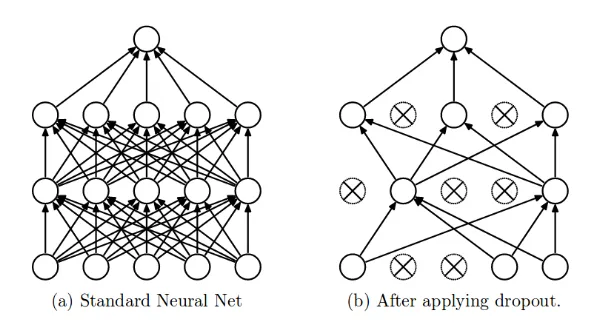

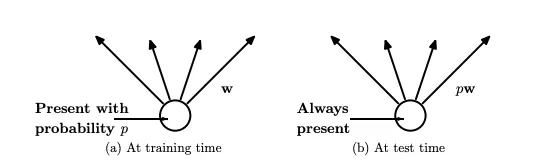

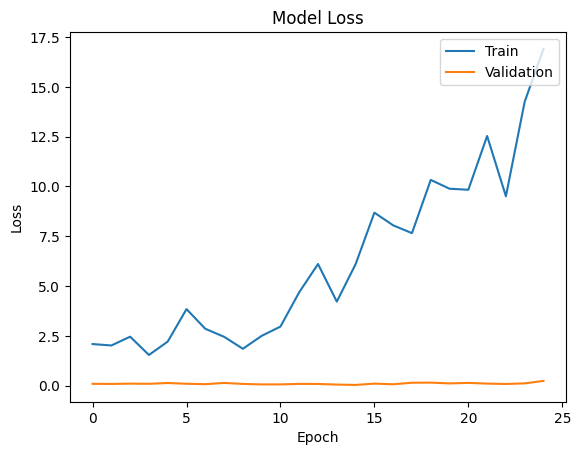

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [42]:

ann.summary()
models.save_model(ann, './model_ann_2024.keras')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │         7,140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           305 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,317 (130.15 KB)

 Trainable params: 11,105 (43.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,212 (86.77 KB)

In [43]:
#ann=models.load_model('/content/drive/MyDrive/Colab Notebooks/model_ann_2023')
#ann.summary()

In [44]:
# Build Confusion Matrix
samples = X_test.shape[0]
t_0=time.monotonic()
y_predicted = ann.predict(x=X_test)
t_1=time.monotonic()
y_pred_classes = np.argmax(y_predicted,axis = 1)
y_true = np.argmax(y_test,axis = 1)

print('\nTime per instance: ',(t_1-t_0)/samples*1000,' ms')


6719/6719 ━━━━━━━━━━━━━━━━━━━━ 3s 506us/step

Time per instance:  0.02114744580111283  ms


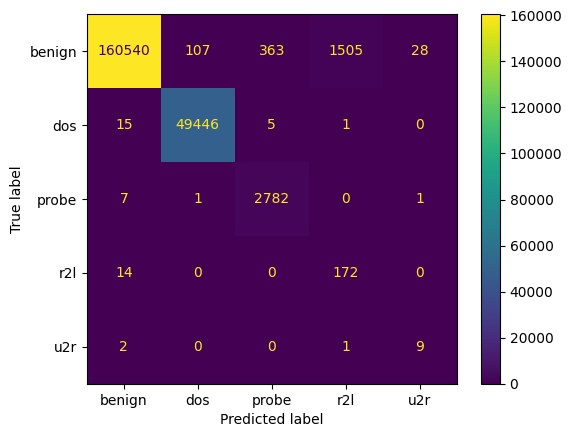

In [45]:
results_ann = confusion_matrix(y_true, y_pred_classes)
error_ann = zero_one_loss(y_true, y_pred_classes)

disp_ann = ConfusionMatrixDisplay(confusion_matrix=results_ann, display_labels=label_ann)
disp_ann.plot()
plt.show()

In [46]:
precision_score(y_true,y_pred_classes,average=None)

array([0.99976335, 0.99782056, 0.8831746 , 0.10244193, 0.23684211])

In [47]:
recall_score(y_true,y_pred_classes,average=None)

array([0.98767711, 0.99957547, 0.99677535, 0.92473118, 0.75      ])

In [48]:
f1_score(y_true,y_pred_classes,average=None)

array([0.99368348, 0.99869725, 0.93654267, 0.1844504 , 0.36      ])

In [49]:
# Binary random forest

In [50]:
y_train_t_bin = np.argmax(y_train_t,axis = 1)
y_test_bin = np.argmax(y_test,axis = 1)
y_val_bin = np.argmax(y_val,axis = 1)

for x in np.arange(0,len(y_train_t_bin)): y_train_t_bin[x]=min(y_train_t_bin[x],1)
for x in np.arange(0,len(y_test_bin)): y_test_bin[x]=min(y_test_bin[x],1)
for x in np.arange(0,len(y_val_bin)): y_val_bin[x]=min(y_val_bin[x],1)



Training:  33.66143118031323 seconds
Classification:  1.0035012504085898 seconds
Classification time per instance  4.667469385478955e-06
[[162533     10]
 [    46  52410]] 
Error:  0.0002604663277503416


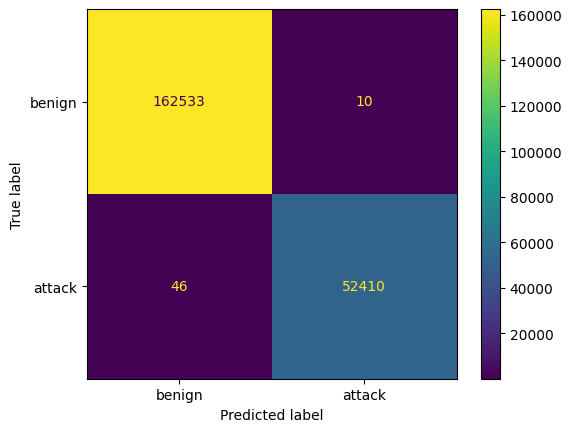

In [51]:
from sklearn.ensemble import RandomForestClassifier

t0 = time.monotonic()
#classifier_rf = RandomForestClassifier(criterion='entropy', random_state=10)
classifier_rf_bin = RandomForestClassifier(n_estimators=101, criterion='entropy', random_state=42)
classifier_rf_bin.fit(X_train_t,y_train_t_bin)
t1 = time.monotonic()
pred_label_cat_rf_bin = classifier_rf_bin.predict(X_test)
t2 = time.monotonic()

results_rf_bin = confusion_matrix(y_test_bin, pred_label_cat_rf_bin)
error_rf_bin = zero_one_loss(y_test_bin, pred_label_cat_rf_bin)

print('\nTraining: ',(t1-t0),'seconds\nClassification: ',(t2-t1),'seconds\nClassification time per instance ', (t2-t1)/len(y_test_bin))
print(results_rf_bin,'\nError: ',error_rf_bin)

label_bin=['benign','attack']
disp_rf_bin = ConfusionMatrixDisplay(confusion_matrix=results_rf_bin, display_labels=label_bin)
disp_rf_bin.plot()
plt.show()

In [52]:
ann_bin = models.Sequential()
ann_bin.add(layer=layers.Dense(units=30, activation='relu', input_shape=[X_train_t.shape[1]]))
ann_bin.add(layers.Dropout(0.2))
ann_bin.add(layer=layers.Dense(units=5, activation='relu'))
ann_bin.add(layers.Dropout(0.1))
ann_bin.add(layer=layers.Dense(units=1, activation='sigmoid'))

ann_bin.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

es_bin = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history_bin = ann_bin.fit(x=X_train_t, y=y_train_t_bin, epochs=100, verbose=1, validation_data=(X_val, y_val_bin), callbacks=[es_bin])

/home/jovyan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9917 - loss: 0.0497 - val_accuracy: 0.9980 - val_loss: 0.0081
Epoch 2/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.9981 - val_loss: 0.0063
Epoch 3/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9982 - val_loss: 0.0051
Epoch 4/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9983 - loss: 0.0058 - val_accuracy: 0.9984 - val_loss: 0.0053
Epoch 5/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9988 - val_loss: 0.0046
Epoch 6/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.9987 - loss: 0.0048 - val_accuracy: 0.9989 - val_loss: 0.0040
Epoch 7/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - accuracy: 0.9987 - loss: 0.0045 - val_accuracy: 0.9991 - val_loss: 0.0037
Epoch 8/100
21500/21500 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - ac

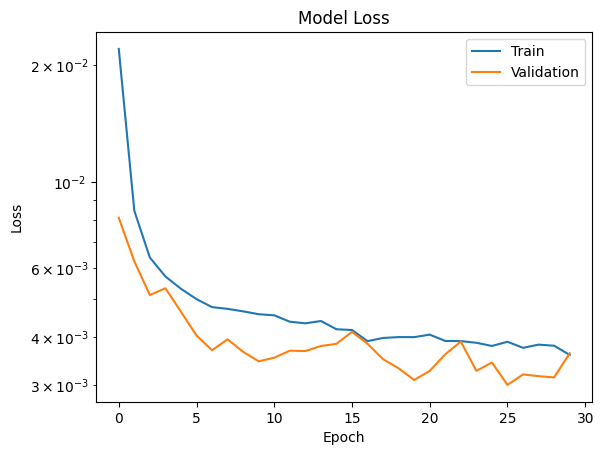

In [53]:
plt.plot(history_bin.history['loss'])
plt.plot(history_bin.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.yscale('log')
plt.show()

In [54]:
ann_bin.summary()
models.save_model(ann_bin, './model_ann_bin_10_2023.keras')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 30)             │         3,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,195 (43.73 KB)

 Trainable params: 3,731 (14.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,464 (29.16 KB)

In [55]:
#ann_bin=models.load_model('/model_ann_bin_10_2023.keras')
#ann_bin.summary()

In [56]:
samples = X_test.shape[0]
t_0=time.monotonic()
y_predicted_bin = ann_bin.predict(x=X_test)
t_1=time.monotonic()
y_pred_classes_bin = (y_predicted_bin > 0.5)


print('\nTime per instance: ',(t_1-t_0)/samples*1000,' ms')

6719/6719 ━━━━━━━━━━━━━━━━━━━━ 3s 382us/step

Time per instance:  0.01580203316457705  ms


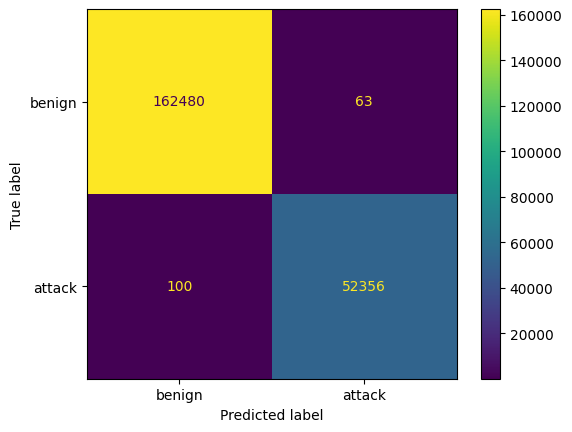

In [57]:
results_ann_bin = confusion_matrix(y_test_bin, y_pred_classes_bin)
error_ann_bin = zero_one_loss(y_test_bin, y_pred_classes_bin)

disp_ann = ConfusionMatrixDisplay(confusion_matrix=results_ann_bin, display_labels=label_bin)
disp_ann.plot()
plt.show()

In [58]:
new_train_attack = np.c_[X_train_t, y_train_t]
print(new_train_attack.shape)
new_val_attack = np.c_[X_val, y_val]
print(new_val_attack.shape)

(687994, 123)
(171999, 123)


In [59]:
new_train_attack = np.delete(new_train_attack, np.where(new_train_attack[:,X_train_t.shape[1]]==1), axis=0)
print(new_train_attack.shape)
new_val_attack = np.delete(new_val_attack, np.where(new_val_attack[:,X_val.shape[1]]==1), axis=0)
print(new_val_attack.shape)

(168201, 123)
(41521, 123)


In [60]:
# Drop real 'benign' traffic from X_train_t and X_val dataset
label_attack=new_train_attack[:,slice(X_train_t.shape[1],new_train_attack.shape[1])]
print(label_attack.shape)
new_train_attack=np.delete(new_train_attack,slice(X_train_t.shape[1], X_train_t.shape[1]+label_attack.shape[1]),axis=1)
print(new_train_attack.shape)

label_attack_val=new_val_attack[:,slice(X_val.shape[1],new_val_attack.shape[1])]
print(label_attack_val.shape)
new_val_attack=np.delete(new_val_attack,slice(X_val.shape[1], X_val.shape[1]+label_attack_val.shape[1]),axis=1)
print(new_val_attack.shape)

(168201, 5)
(168201, 118)
(41521, 5)
(41521, 118)


In [61]:
# Drop traffic estimated as 'benign' from RF binary classifier in the test dataset
new_test_attack=np.c_[X_test, pred_label_cat_rf_bin, y_test]
print(new_test_attack.shape)
new_test_attack=np.delete(new_test_attack,  np.where(new_test_attack[:,X_test.shape[1]]==0), axis=0  )
y_test_numeric=new_test_attack[:,slice(new_test_attack.shape[1]-y_test.shape[1], new_test_attack.shape[1])]
new_test_attack=np.delete(new_test_attack, slice(X_test.shape[1],new_test_attack.shape[1]), axis=1)
print(new_test_attack.shape)
print(y_test_numeric.shape)

(214999, 124)
(52420, 118)
(52420, 5)


In [62]:
n_features = new_train_attack.shape[1]

total_sum=np.sum(label_attack)
cat_attack=np.sum(label_attack,axis=0)
print(total_sum, cat_attack[0], cat_attack[1], cat_attack[2], cat_attack[3], cat_attack[4],'\n')

168201.0 0.0 158708.0 8821.0 641.0 31.0 



In [63]:
label_attack_ann = label_attack[:,1:5]
label_attack_ann.shape

label_attack_val_ann = label_attack_val[:,1:5]
label_attack_val_ann.shape

(41521, 4)

In [64]:
class_weight_KDD_attack = {0: 1,
                1: cat_attack[1]/cat_attack[2],
                2: cat_attack[1]/cat_attack[3],
                3: cat_attack[1]/cat_attack[4]}

ann_attack = models.Sequential()
ann_attack.add(layer=layers.Dense(units=20, activation='relu', input_shape=[n_features]))
ann_attack.add(layers.Dropout(0.2))
ann_attack.add(layer=layers.Dense(units=20, activation='relu'))
ann_attack.add(layers.Dropout(0.2))
ann_attack.add(layer=layers.Dense(units=4, activation='softmax'))

ann_attack.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es_attack = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, restore_best_weights=True)
history = ann_attack.fit(x=new_train_attack, y=label_attack_ann, epochs=100, verbose=1, validation_data=(new_val_attack, label_attack_val_ann), class_weight=class_weight_KDD_attack, callbacks=[es_attack])

Epoch 1/100


/home/jovyan/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5257/5257 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9348 - loss: 3.0049 - val_accuracy: 0.9983 - val_loss: 0.0083
Epoch 2/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9879 - loss: 1.3551 - val_accuracy: 0.9989 - val_loss: 0.0043
Epoch 3/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9944 - loss: 0.8070 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 4/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9947 - loss: 0.5801 - val_accuracy: 0.9988 - val_loss: 0.0039
Epoch 5/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9955 - loss: 0.6871 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 6/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9951 - loss: 0.5441 - val_accuracy: 0.9995 - val_loss: 0.0024
Epoch 7/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9969 - loss: 0.4782 - val_accuracy: 0.9995 - val_loss: 0.0027
Epoch 8/100
5257/5257 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9968 - loss: 0.5597 - val_

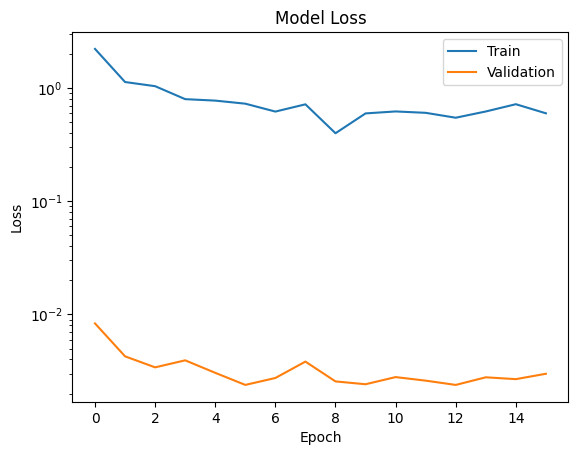

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.yscale('log')
plt.show()

In [66]:
ann_attack.summary()
models.save_model(ann_attack, './model_ann_hier_2023.keras')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 20)             │         2,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            84 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,654 (33.81 KB)

 Trainable params: 2,884 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,770 (22.54 KB)

In [67]:
#ann_attack=models.load_model('/content/drive/MyDrive/Colab Notebooks/model_ann_hier_2023')
#ann_attack.summary()

In [68]:
# Build Confusion Matrix
samples_h = new_test_attack.shape[0]
t_0=time.monotonic()
y_predicted_h = ann_attack.predict(x=new_test_attack)
t_1=time.monotonic()
y_pred_classes_h = np.argmax(y_predicted_h,axis = 1)+1
y_true_h = np.argmax(y_test_numeric,axis = 1)

print('\nTime per instance: ',(t_1-t_0)/samples_h*1000,' ms')

1639/1639 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step

Time per instance:  0.02197772735294178  ms


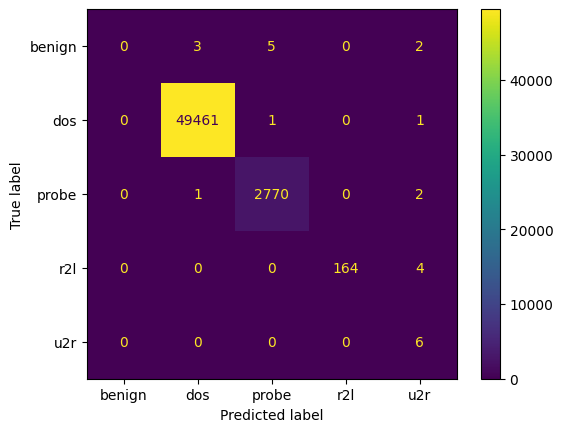

In [69]:
results_ann_h = confusion_matrix(y_true_h, y_pred_classes_h)
error_ann_h = zero_one_loss(y_true_h, y_pred_classes_h)

disp_ann_h = ConfusionMatrixDisplay(confusion_matrix=results_ann_h, display_labels=label_ann)
disp_ann_h.plot()
plt.show()